# Optimization and Algorithms

## Project Code

### Authors
Group 31:

Francisco Martins, Sara Monteiro, Mike Kanter and Filipe Martins

#### Load of required packages

In [1]:
import numpy as np
import scipy.io
import cvxpy as cp
import matplotlib.pyplot as plt

## 1. Source Localization

* definition of the cost function (non convex)

In [2]:
def non_convex_function(x, a, r):
    norm = np.linalg.norm(x - a, axis=-1)
    diff = norm - r
    diff_sq = diff**2
    sum_sq = np.sum(diff_sq, axis=0)
    return sum_sq

* definition of the relaxed cost function (convex)

In [3]:
def convex_function(x, a, r):
    norm = np.linalg.norm(x - a, axis=-1)
    diff = norm - r
    diff_pos = np.where(diff < 0, 0, diff)
    diff_sq = diff_pos**2
    sum_sq = np.sum(diff_sq, axis=0)
    return sum_sq

* $\textbf{plot_contours_ranges(cost_function, data, plot_data, prob_dim, plot_type)}$:
function to produce the required contour plots for the 1 to 3. it works for 1D and 2D cases and for m anchor-range pairs $(a_1,r_1), ..., (a_m,r_m)$
* cost_function = cost function name
* data = [anchors, ranges delta], delta is the step size for spatial points in domain
* plot_data = [range_x, range_y, levels], levels for the contours in 2D case
* prob_dim = problem dimension 1 for the 1D case and 2 for the 2D case
* plot_type = 1 for 1D case and 2 for 2D case

In [4]:
def plot_contours_ranges(cost_function, data, plot_data, prob_dim, plot_type):
    
    if prob_dim == 1:
        # set the parameters, delta is the step size
        anchors, ranges, delta = data[0], data[1], data[2]
        # set plot range
        plot_dim_x = plot_data
        
        # spatial points, the domain
        x = np.arange(*plot_dim_x, delta)
        # anchors and ranges as numpy arrays
        anchors = np.array(anchors)
        ranges = np.array(ranges)
        # list with cost function values
        y_vals = list()
        
        # loop over the points in domain to get cost function values and store the values
        for valx in x:
            y = cost_function(valx, anchors, ranges)
            y_vals.append(y)
        y_vals = np.array(y_vals)
        
        # plot the cost function
        plt.plot(x, y_vals)
        label = 1
        # loop over the anchors to plot them and label them a1,...,am
        for anchor in anchors: 
            plt.scatter(anchor, 0, c='red', marker='o', s=20)
            plt.annotate('a' + str(label), (anchor, 0), textcoords="offset points", xytext=(0, 10), ha='center')
            label = label+1
        # set axes labels
        plt.xlabel('spatial values')
        plt.ylabel('cost function values')
        plt.show()
        
    else:
        # set the parameters
        anchors, ranges, delta = data[0], data[1], data[2]
        # set plot ranges and the levels for the contours
        plot_dim_x, plot_dim_y, levels = plot_data[0], plot_data[1], plot_data[2]
        
        # spatial points, to generate the domain
        x = np.arange(*plot_dim_x, delta)
        y = np.arange(*plot_dim_y, delta)
        # generate the 2D domain
        X, Y = np.meshgrid(x, y)
        grid_points = np.dstack((X, Y)).reshape(-1, 2)
        
        # anchors and ranges as numpy arrays
        a_values = np.array(anchors)
        r_values = np.array(ranges)
        
        # generate the cost function values for the grid domain and given parameters
        Z = cost_function(grid_points, a_values[:, np.newaxis], r_values[:, np.newaxis])
        Z = Z.reshape(X.shape)
        
        if plot_type == 1: # plot with contour levels
            # set figure size
            fig = plt.figure(figsize=(6,6))
            # get plot axes
            ax = plt.axes()
            label = 1
            # loop over the anchors to plot them and label them a1,...,am 
            for point in anchors:
                x_anchor, y_anchor = point
                ax.scatter(x_anchor, y_anchor, c='red', marker='o', s=50)
                ax.annotate('a' + str(label), (x_anchor, y_anchor), textcoords="offset points", xytext=(0, 10), ha='center')
                label += 1
            
            # add the contours to the plot
            CS = ax.contour(X, Y, Z, levels=levels, cmap='terrain')
            # add to contours their level values
            ax.clabel(CS, inline=True, fontsize=10)
            
            # set axes labels
            plt.xlabel('abscissa spatial component')
            plt.ylabel('ordinate spatial component')
            # add a color bar for the level values
            plt.colorbar(CS)
        
        elif plot_type == 2: # plot with filled contours
            # set figure size
            plt.figure(figsize=(6,6))
            
            # add the filled contours to the plot
            CS = plt.contourf(X, Y, Z, levels=levels, cmap='terrain')
            label = 1
            
            # loop over the anchors to plot them and label them a1,...,am
            for point in anchors:
                x_anchor, y_anchor = point
                plt.scatter(x_anchor, y_anchor, c='red', marker='o', s=50)
                plt.annotate('a' + str(label), (x_anchor, y_anchor), textcoords="offset points", xytext=(0, 10), ha='center')
                label += 1
            
            # set axes labels
            plt.xlabel('abscissa spatial component')
            plt.ylabel('ordinate spatial component')
            # add a color bar for the level values
            plt.colorbar(CS)

        plt.show()

* $\textbf{cvx_solution_ranges(anchors, ranges, prob_dim)}$: function to produce the approximate solution of the relaxed problem, using cvx. it works for an n-dimensional problem and for m anchor-range pairs $(a_1,r_1),...,(a_m,r_m)$ 

In [5]:
def cvx_solution_ranges(anchors, ranges, prob_dim):
    # set cvx spatial variable (n-dimensional)
    x_var = cp.Variable(prob_dim)
    # set anchors and range as numpy arrays
    anchors = np.array(anchors)
    ranges = np.array(ranges)
    # list to store the differences x - a1, ..., x - am
    diff_vals = list()
    
    # loop over the anchors to store the differences, with the cvx variable 
    for anchor in anchors:
        diff = x_var - anchor
        diff_vals.append(diff)
    
    # verticaly stack the differences (diffs as a cvx column vector)
    diff_vec = cp.vstack(diff_vals)
    # define the cost function within cvx 
    cost_function = cp.sum(cp.square(cp.maximum(0, cp.norm(diff_vec, axis=1) - ranges)))
    
    # set objective to minize the cost function
    objective = cp.Minimize(cost_function)
    # set the optimization problem
    problem = cp.Problem(objective)
    # solve the prompt cvx problem
    problem.solve()
    
    # get the obtained solution
    optimal_x = x_var.value
    # get the problem status
    prob_status = problem.status
    # get the cost value for obtained solution
    prob_value = problem.value
    
    return [np.array(optimal_x), prob_status, np.array(prob_value)]

* $\textbf{plot_contours_cvx_ranges(cost_function, data, plot_data, prob_dim, plot_type)}$:
function to produce contour plots together with obtained cvx solution. it works for 1D and 2D cases and for m anchor-range pairs $(a_1,r_1), ..., (a_m,r_m)$
* cost_function = cost function name
* data = [anchors, ranges delta], delta is the step size for spatial points in domain
* plot_data = [range_x, range_y, levels], levels for the contours in 2D case
* prob_dim = problem dimension 1 for 1D case and 2 for 2D case, if greater than 2 only returns cvx results
* plot_type = 1 for 1D case and 2 for 2D case

In [6]:
def plot_contours_cvx_ranges(cost_function, data, plot_data, prob_dim, plot_type):
    
    if prob_dim == 1: # 1D case
        # set the parameters
        anchors, ranges, delta = data[0], data[1], data[2]
        # set plot range
        plot_dim_x = plot_data
        
        # call cvx function
        res_cvx = cvx_solution_ranges(anchors, ranges, prob_dim)
        # print results obtained from cvx solver
        print('The obtained (approx) optimal solution is x = ', res_cvx[0])
        print('Problem status solution: ', res_cvx[1])
        print('Cost value at obtained solution: ', res_cvx[2])
        
        # spatial points, the domain
        x = np.arange(*plot_dim_x, delta)
        
        # set anchors and ranges as numpy arrays
        anchors = np.array(anchors)
        ranges = np.array(ranges)
        # list with cost function values
        y_vals = list()
        
        # loop over the points in domain to get cost function values and store the values
        for valx in x:
            y = cost_function(valx, anchors, ranges)
            y_vals.append(y)
        y_vals = np.array(y_vals)
        
        # plot the cost function
        plt.plot(x, y_vals)
        label = 1
        # loop over the anchors to plot them and label them a1,...,am
        for anchor in anchors:
            plt.scatter(anchor, 0, c='red', marker='o', s=20)
            plt.annotate('a' + str(label), (anchor, 0), textcoords="offset points", xytext=(0, 10), ha='center')
            label = label+1
        
        # add to plot the cvx solution
        plt.scatter(res_cvx[0], c='red', marker='x', s=20)
        # label the solution
        plt.annotate('$\hat{x}$', res_cvx[0][0], textcoords="offset points", xytext=(0, 10), ha='center')
        
        # set axes labels
        plt.xlabel('spatial values')
        plt.ylabel('cost function values')
        plt.show()
        
    elif prob_dim == 2: # 2D case        
        # set the parameters
        anchors, ranges, delta = data[0], data[1], data[2]
        # set plot ranges and the levels for the contours
        plot_dim_x, plot_dim_y, levels = plot_data[0], plot_data[1], plot_data[2]
        
        # call cvx function
        res_cvx = cvx_solution_ranges(anchors, ranges, prob_dim)
        # print results obtained from cvx solver
        print('The obtained (approx) optimal solution is x = ', res_cvx[0])
        print('Problem status solution: ', res_cvx[1])
        print('Cost value at obtained solution: ', res_cvx[2])
        
        # spatial points, to generate the domain
        x = np.arange(*plot_dim_x, delta)
        y = np.arange(*plot_dim_y, delta)
        # generate the 2D domain
        X, Y = np.meshgrid(x, y)
        grid_points = np.dstack((X, Y)).reshape(-1, 2)
        
        # anchors and ranges as numpy arrays
        anchors = np.array(anchors)
        ranges = np.array(ranges)
        
        # generate the cost function values for the grid domain and given parameters
        Z = cost_function(grid_points, anchors[:, np.newaxis, :], ranges[:, np.newaxis])
        Z = Z.reshape(X.shape)
        
        if plot_type == 1: # for contour levels
            # set figure size
            fig = plt.figure(figsize=(6,6))
            
            # get plot axes
            ax = plt.axes()
            label = 1
            # loop over the anchors to plot them and label them a1,...,am
            for anchor in anchors:
                x_anchor, y_anchor = anchor
                ax.scatter(x_anchor, y_anchor, c='red', marker='o', s=50)
                ax.annotate('a' + str(label), (x_anchor, y_anchor), textcoords="offset points", xytext=(0, 10), ha='center')
                label += 1
            # add to plot the cvx solution
            ax.scatter(res_cvx[0][0], res_cvx[0][1], c='red', marker='x', s=60)
            # label the solution
            ax.annotate('$\hat{x}$', (res_cvx[0][0], res_cvx[0][1]), textcoords="offset points", xytext=(0, 20), ha='center')
           
            # add the contours to the plot
            CS = ax.contour(X, Y, Z, levels=levels, cmap='terrain')
            # add to contours their level values
            ax.clabel(CS, inline=True, fontsize=10)
            # set axes labels
            plt.xlabel('abscissa spatial component')
            plt.ylabel('ordinate spatial component')
            # add a color bar for the level values
            plt.colorbar(CS)
        
        else: # for filled contours
            # set figure size
            plt.figure(figsize=(6,6))
            # add filled ontours to the plot
            CS = plt.contourf(X, Y, Z, levels=levels, cmap='terrain')

            label = 1
            # loop over the anchors to plot them and label them a1,...,am
            for point in anchors:
                x_anchor, y_anchor = point
                plt.scatter(x_anchor, y_anchor, c='red', marker='o', s=50)
                plt.annotate('a' + str(label), (x_anchor, y_anchor), textcoords='offset points', xytext=(0, 10), ha='center')
                label += 1
            
            # add to plot the cvx solution
            plt.scatter(res_cvx[0][0], res_cvx[0][1], c='red', marker='x', s=60)
            # label the solution
            plt.annotate('$\hat{x}$', (res_cvx[0][0], res_cvx[0][1]), textcoords='offset points', xytext=(0, 20), ha='center')
            
            # set axes labels
            plt.xlabel('abscissa spatial component')
            plt.ylabel('ordinate spatial component')
            # add color bar for the level values
            plt.colorbar(CS)
        
    else: # if dim greater than 2
        # call cvx solution
        res_cvx = cvx_solution_ranges(anchors, ranges, prob_dim)
        # print results obtained from cvx solver
        print('The obtained (approx) optimal solution is x = ', res_cvx[0])
        print('Problem status solution: ', res_cvx[1])
        print('Cost value at obtained solution: ', res_cvx[2])

### 1.1 Task 1

* non-convex cost function $f(x) = \sum_{k=1}^M (\|x - a_k\| - r_k)^2$

* non-convexity for the 1D case

$f(t x + (1 - t) y)$

In [7]:
non_convex_function(0.5*np.array([1]) + 0.5*np.array([3]),2,1)

1.0

$t f(x) + (1 - t) f(y)$

In [8]:
0.5*non_convex_function(np.array([1]),2,1) + 0.5*non_convex_function(np.array([3]),2,1)

0.0

* plot of the 1D non-convex cost function

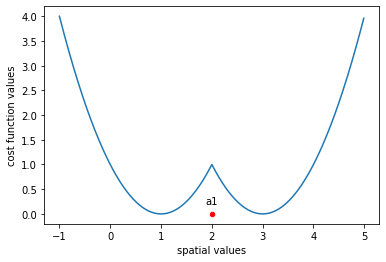

In [9]:
anchors = [2]
ranges = [1]
delta = 0.01
plot_range = [-1, 5]
data = [anchors, ranges, delta]
plot_data = plot_range
prob_dim = 1

plot_contours_ranges(non_convex_function, data, plot_data, prob_dim, _)

### 1.2 Task 2

#### First part, tow anchors

* non-convexity

$f(t x + (1 - t) y)$

In [10]:
non_convex_function(0.5*np.array((0,-1))+0.5*np.array((0,1)),np.array((-1,0)),2) + \
    non_convex_function(0.5*np.array((0,-1))+0.5*np.array((0,1)),np.array((3,0)),3)

1.0

$t f(x) + (1 - t) f(y)$

In [11]:
0.5*(non_convex_function(np.array((0,-1)),np.array((-1,0)),2) + \
         non_convex_function(np.array((0,-1)),np.array((3,0)),3)) + \
    0.5*(non_convex_function(np.array((0,1)),np.array((-1,0)),2) + \
             non_convex_function(np.array((0,1)),np.array((3,0)),3))

0.3694797894973438

* plot of the non-convex cost function (with contour levels)

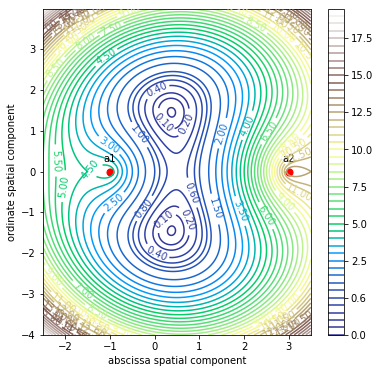

In [12]:
anchors = [(-1,0), (3,0)]
ranges = [2, 3]
delta = 0.01

plot_dim_x = (-2.5,3.5)
plot_dim_y = (-4,4)
levels = np.array([0, 0.01, 0.1] + list(np.arange(0.2, 0.9, 0.2)) + list(np.arange(1,20,0.5)))

prob_dim = 2
plot_type = 1

data = [anchors, ranges, delta]
plot_data = [plot_dim_x, plot_dim_y, levels]

plot_contours_ranges(non_convex_function, data, plot_data, prob_dim, plot_type)

* plot of the non-convex cost function (with filled contours)

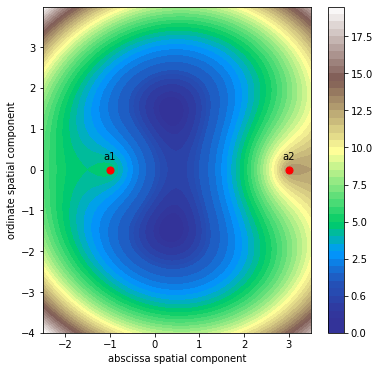

In [13]:
plot_type = 2

plot_contours_ranges(non_convex_function, data, plot_data, prob_dim, plot_type)

#### Second part, three anchors

* one more anchor $a_3 = (0,2)$ with measured ranges $r_3 \in \{r_1^*,1.2,2.8,r_2^*\}$

In [14]:
r_1_star = np.linalg.norm(np.array((3/8,3*np.sqrt(15)/8)) - np.array((0,2)))
r_1_star

0.6637205591880324

In [15]:
r_2_star = np.linalg.norm(np.array((3/8,-3*np.sqrt(15)/8)) - np.array((0,2)))
r_2_star

3.4726754843076146

##### For $r_3 = r_1^*$:

* non-convexity

$f(t x + (1 - t) y)$

In [16]:
non_convex_function(0.5*np.array((-0.8,-0.2))+0.5*np.array((-1.2,0.2)),np.array((-1,0)),2) + \
    non_convex_function(0.5*np.array((-0.8,0.2))+0.5*np.array((-1.2,0.2)),np.array((3,0)),3) + \
        non_convex_function(0.5*np.array((-0.8,-0.2))+0.5*np.array((-1.2,0.2)),np.array((2,0)),r_1_star)

10.468220352159737

$t f(x) + (1 - t) f(y)$

In [17]:
0.5*(non_convex_function(np.array((-0.8,-0.2)),np.array((-1,0)),2) + \
         non_convex_function(np.array((-0.8,-0.2)),np.array((3,0)),3) + \
             non_convex_function(np.array((-0.8,-0.2)),np.array((0,2)),r_1_star)) + \
0.5*(non_convex_function(np.array((-1.2,0.2)),np.array((-1,0)),2) + \
         non_convex_function(np.array((-1.2,0.2)),np.array((3,0)),3) + \
            non_convex_function(np.array((-1.2,0.2)),np.array((0,2)),r_1_star))

6.529520852335508

* contour plot with contour levels

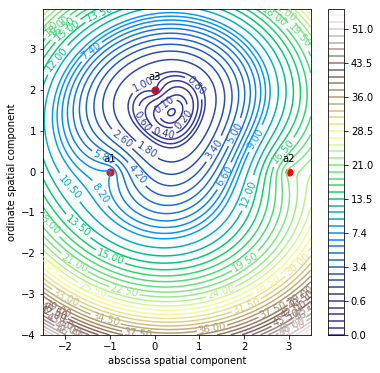

In [18]:
anchors = [(-1,0), (3,0), (0,2)]
ranges = [2, 3, r_1_star]
delta = 0.01

plot_dim_x = (-2.5,3.5)
plot_dim_y = (-4,4)
levels2 = np.array([0, 0.01, 0.1] + list(np.arange(0.2, 0.9, 0.2)) + \
                      list(np.arange(1,9,0.8)) + list(np.arange(9,57,1.5)))

data = [anchors, ranges, delta]
plot_data = [plot_dim_x, plot_dim_y, levels2]

prob_dim = 2
plot_type = 1

plot_contours_ranges(non_convex_function, data, plot_data, prob_dim, plot_type)

* contour plot with filled contours

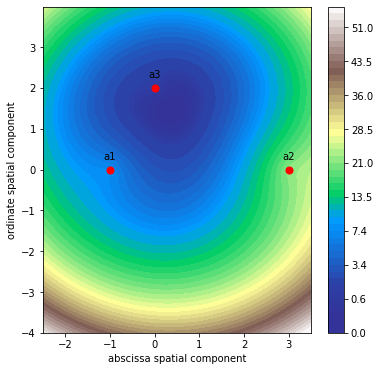

In [19]:
plot_type = 2

plot_contours_ranges(non_convex_function, data, plot_data, prob_dim, plot_type)

##### For $r_3 = 1.2$:

* non-convexity

$f(t x + (1 - t) y)$

In [20]:
non_convex_function(0.5*np.array((-0.8,-0.2))+0.5*np.array((-1.2,0.2)),np.array((-1,0)),2) + \
    non_convex_function(0.5*np.array((-0.8,0.2))+0.5*np.array((-1.2,0.2)),np.array((3,0)),3) + \
        non_convex_function(0.5*np.array((-0.8,-0.2))+0.5*np.array((-1.2,0.2)),np.array((2,0)),1.2)

8.250018726599057

$t f(x) + (1 - t) f(y)$

In [21]:
0.5*(non_convex_function(np.array((-0.8,-0.2)),np.array((-1,0)),2) + \
         non_convex_function(np.array((-0.8,-0.2)),np.array((3,0)),3) + \
             non_convex_function(np.array((-0.8,-0.2)),np.array((0,2)),1.2)) + \
0.5*(non_convex_function(np.array((-1.2,0.2)),np.array((-1,0)),2) + \
         non_convex_function(np.array((-1.2,0.2)),np.array((3,0)),3) + \
             non_convex_function(np.array((-1.2,0.2)),np.array((0,2)),1.2))

5.11344807395329

* contour plot with contour levels

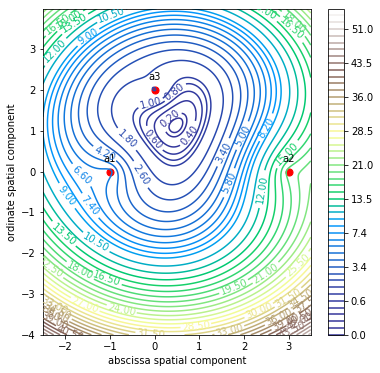

In [22]:
anchors = [(-1,0), (3,0), (0,2)]
ranges = [2, 3, 1.2]
delta = 0.01

plot_dim_x = (-2.5,3.5)
plot_dim_y = (-4,4)
levels3 = np.array([0, 0.01, 0.15] + list(np.arange(0.2, 0.9, 0.2)) + \
                      list(np.arange(1,9,0.8)) + list(np.arange(9,57,1.5)))

data = [anchors, ranges, delta]
plot_data = [plot_dim_x, plot_dim_y, levels3]

prob_dim = 2
plot_type = 1

plot_contours_ranges(non_convex_function, data, plot_data, prob_dim, plot_type)

* contour plot with filled contours

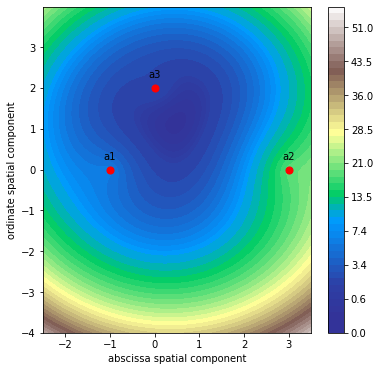

In [23]:
plot_type = 2

plot_contours_ranges(non_convex_function, data, plot_data, prob_dim, plot_type)

##### For $r_3 = 2.8$: 

* non-convexity

$f(t x + (1 - t) y)$

In [24]:
non_convex_function(0.5*np.array((-0.8,-0.2))+0.5*np.array((-1.2,0.2)),np.array((-1,0)),2) + \
    non_convex_function(0.5*np.array((-0.8,0.2))+0.5*np.array((-1.2,0.2)),np.array((3,0)),3) + \
        non_convex_function(0.5*np.array((-0.8,-0.2))+0.5*np.array((-1.2,0.2)),np.array((2,0)),2.8)

5.050018726599057

$t f(x) + (1 - t) f(y)$

In [25]:
0.5*(non_convex_function(np.array((-0.8,-0.2)),np.array((-1,0)),2) + \
         non_convex_function(np.array((-0.8,-0.2)),np.array((3,0)),3) + \
             non_convex_function(np.array((-0.8,-0.2)),np.array((0,2)),2.8)) + \
0.5*(non_convex_function(np.array((-1.2,0.2)),np.array((-1,0)),2) + \
         non_convex_function(np.array((-1.2,0.2)),np.array((3,0)),3) + \
             non_convex_function(np.array((-1.2,0.2)),np.array((0,2)),2.8))

4.30661487807758

* contour plot with contour levels

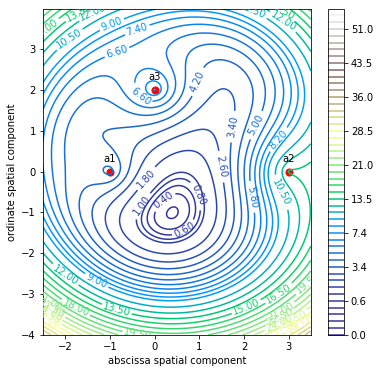

In [26]:
anchors = [(-1,0), (3,0), (0,2)]
ranges = [2, 3, 2.8]
delta = 0.01

plot_dim_x = (-2.5,3.5)
plot_dim_y = (-4,4)

data = [anchors, ranges, delta]
plot_data = [plot_dim_x, plot_dim_y, levels3]

prob_dim = 2
plot_type = 1

plot_contours_ranges(non_convex_function, data, plot_data, prob_dim, plot_type)

* contour plot with filled contours

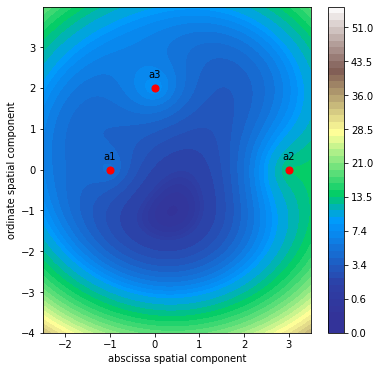

In [27]:
plot_type = 2

plot_contours_ranges(non_convex_function, data, plot_data, prob_dim, plot_type)

##### For $r_3 = r_2^*$:

* non-convexity (nao e este o ponto)

$f(t x + (1 - t) y)$

In [64]:
non_convex_function(0.5*np.array((-0.2,2.1))+0.5*np.array((-0.2,2)),np.array((-1,0)),2) + \
    non_convex_function(0.5*np.array((-0.2,2.1))+0.5*np.array((-0.2,2)),np.array((3,0)),3) + \
        non_convex_function(0.5*np.array((-0.2,2.1))+0.5*np.array((-0.2,2)),np.array((2,0)),r_2_star)

0.8975377869421908

$t f(x) + (1 - t) f(y)$

In [65]:
0.5*(non_convex_function(np.array((-0.2,2.1)),np.array((-0.2,2.1)),2) + \
         non_convex_function(np.array((-0.2,2.1)),np.array((3,0)),3) + \
             non_convex_function(np.array((-0.2,2.1)),np.array((0,2)),r_2_star)) + \
0.5*(non_convex_function(np.array((-0.2,2)),np.array((-1,0)),2) + \
         non_convex_function(np.array((-0.2,2)),np.array((3,0)),3) + \
             non_convex_function(np.array((-0.2,2)),np.array((0,2)),r_2_star))

13.286921348200408

* contour plot with contour levels

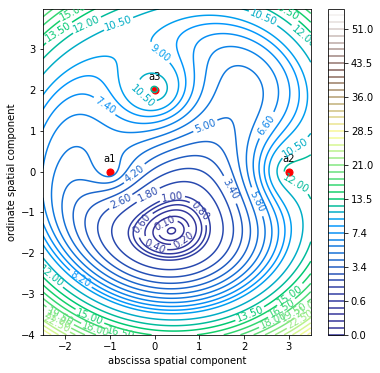

In [30]:
anchors = [(-1,0), (3,0), (0,2)]
ranges = [2, 3, r_2_star]
delta = 0.01

plot_dim_x = (-2.5,3.5)
plot_dim_y = (-4,4)

data = [anchors, ranges, delta]
plot_data = [plot_dim_x, plot_dim_y, levels2]

prob_dim = 2
plot_type = 1

plot_contours_ranges(non_convex_function, data, plot_data, prob_dim, plot_type)

* contour plot with filled contours

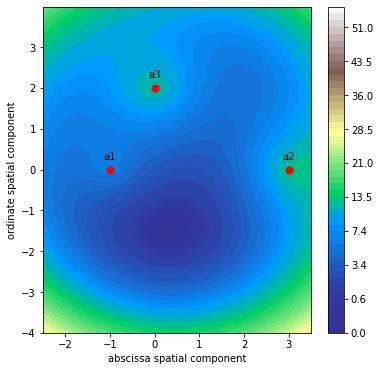

In [31]:
plot_type = 2

plot_contours_ranges(non_convex_function, data, plot_data, prob_dim, plot_type)

### 1.3. Task 3

* relaxed cost function $f(x) = \sum_{k=1}^M (\|x - a_k\| - r_k)_+^2$

#### 1 D case

* plot of the 1D relaxed convex cost function

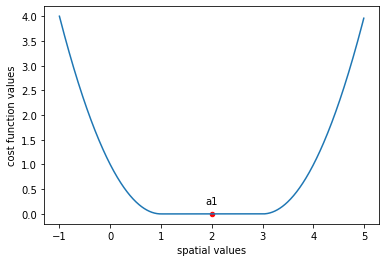

In [32]:
anchors = [2]
ranges = [1]
delta = 0.01

plot_range = [-1, 5]

data = [anchors, ranges, delta]
plot_data = plot_range

prob_dim = 1

plot_contours_ranges(convex_function, data, plot_data, prob_dim, _)

#### 2 D case

* plot of the relaxed cost function (convex) (1)

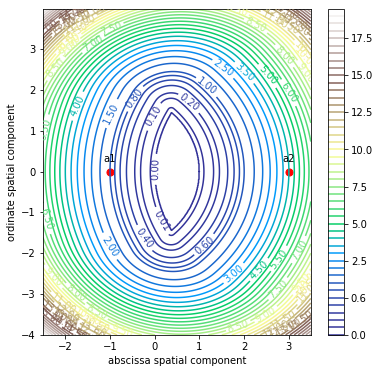

In [33]:
anchors = [(-1,0), (3,0)]
ranges = [2, 3]
delta = 0.01

plot_dim_x = (-2.5,3.5)
plot_dim_y = (-4,4)

data = [anchors, ranges, delta]
plot_data = [plot_dim_x, plot_dim_y, levels]

prob_dim = 2
plot_type = 1

plot_contours_ranges(convex_function, data, plot_data, prob_dim, plot_type)

* plot of the non-convex cost function (2)

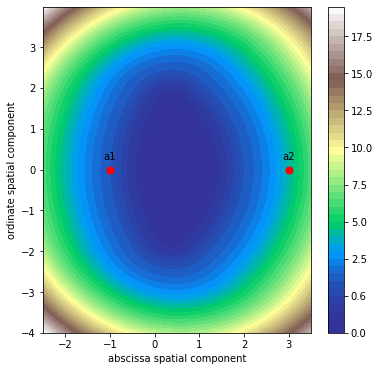

In [34]:
plot_type = 2

plot_contours_ranges(convex_function, data, plot_data, prob_dim, plot_type)

##### For $r_3 = r_1^*$

* contour plot with contours

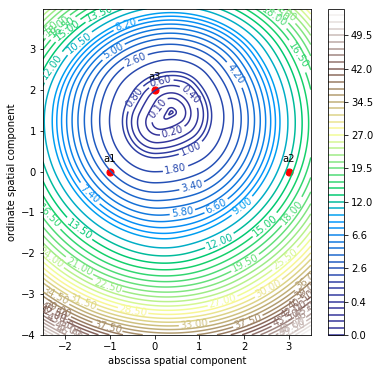

In [35]:
anchors = [(-1,0), (3,0), (0,2)]
ranges = [2, 3, r_1_star]
delta = 0.01

plot_dim_x = (-2.5,3.5)
plot_dim_y = (-4,4)

levels4 = np.array([0, 0.001, 0.01, 0.1] + list(np.arange(0.2, 0.9, 0.2)) + \
                      list(np.arange(1,9,0.8)) + list(np.arange(9,57,1.5)))

data = [anchors, ranges, delta]
plot_data = [plot_dim_x, plot_dim_y, levels4]

prob_dim = 2
plot_type = 1

plot_contours_ranges(convex_function, data, plot_data, prob_dim, plot_type)

* corresponding contour plot (2)

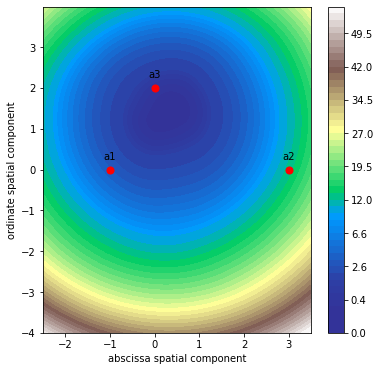

In [36]:
plot_type = 2

plot_contours_ranges(convex_function, data, plot_data, prob_dim, plot_type)

##### For $r_3 = 1.2$:

* contour plot with contour levels

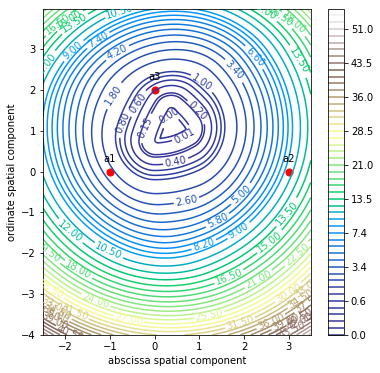

In [37]:
anchors = [(-1,0), (3,0), (0,2)]
ranges = [2, 3, 1.2]
delta = 0.01

plot_dim_x = (-2.5,3.5)
plot_dim_y = (-4,4)

data = [anchors, ranges, delta]
plot_data = [plot_dim_x, plot_dim_y, levels3]

prob_dim = 2
plot_type = 1

plot_contours_ranges(convex_function, data, plot_data, prob_dim, plot_type)

* contour plot with filled contours

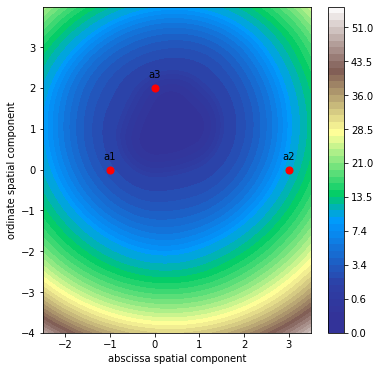

In [38]:
plot_type = 2

plot_contours_ranges(convex_function, data, plot_data, prob_dim, plot_type)

##### For $r_3 = 2.8$:

* contour plot with contour levels

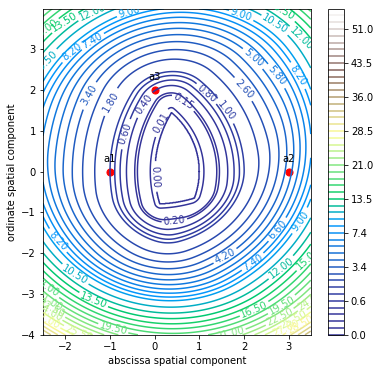

In [39]:
anchors = [(-1,0), (3,0), (0,2)]
ranges = [2, 3, 2.8]
delta = 0.01

plot_dim_x = (-2.5,3.5)
plot_dim_y = (-4,4)

data = [anchors, ranges, delta]
plot_data = [plot_dim_x, plot_dim_y, levels3]

prob_dim = 2
plot_type = 1

plot_contours_ranges(convex_function, data, plot_data, prob_dim, plot_type)

* contour plot with filled contours 

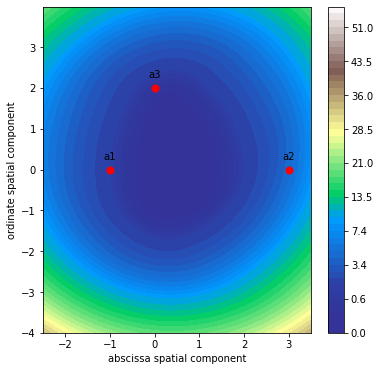

In [40]:
plot_type = 2

plot_contours_ranges(convex_function, data, plot_data, prob_dim, plot_type)

##### For $r_3 = r_2^*$:

* contour plot with contour levels

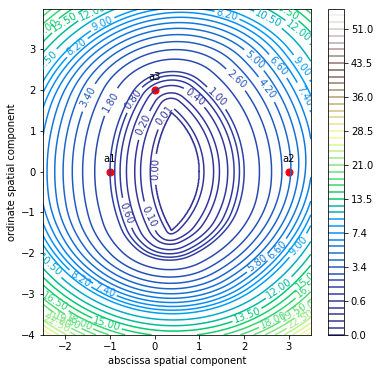

In [41]:
anchors = [(-1,0), (3,0), (0,2)]
ranges = [2, 3, r_2_star]
delta = 0.01

plot_dim_x = (-2.5,3.5)
plot_dim_y = (-4,4)

data = [anchors, ranges, delta]
plot_data = [plot_dim_x, plot_dim_y, levels2]

prob_dim = 2
plot_type = 1

plot_contours_ranges(convex_function, data, plot_data, prob_dim, plot_type)

* contour plot with filled contours

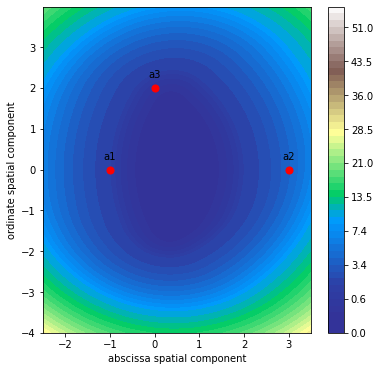

In [42]:
plot_type = 2

plot_contours_ranges(convex_function, data, plot_data, prob_dim, plot_type)

### 1.4 Task 4

#### 2D case of task 3 (2 anchors with relaxed cost function plus cvx solution)

* contour plot with contour levels 

The obtained (approx) optimal solution is x =  [0.51194418 0.        ]
Problem status solution:  optimal
Cost value at obtained solution:  0.0


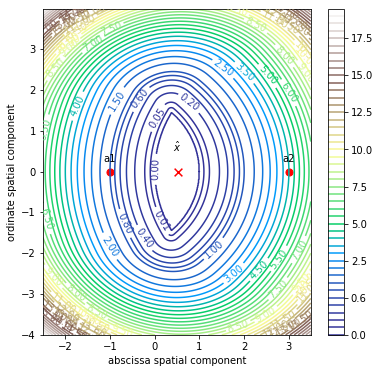

In [44]:
anchors = [(-1,0), (3,0)]
ranges = (2, 3)
delta = 0.01

plot_dim_x = (-2.5,3.5)
plot_dim_y = (-4,4)
levels = np.array([0, 0.01, 0.05] + list(np.arange(0.2, 0.9, 0.2)) + list(np.arange(1,20,0.5)))

data = [anchors, ranges, delta]
plot_data = [plot_dim_x, plot_dim_y, levels]

plot_contours_cvx_ranges(convex_function, data, plot_data, 2, 1)

* contour plot with filled contours

The obtained (approx) optimal solution is x =  [0.51194418 0.        ]
Problem status solution:  optimal
Cost value at obtained solution:  0.0


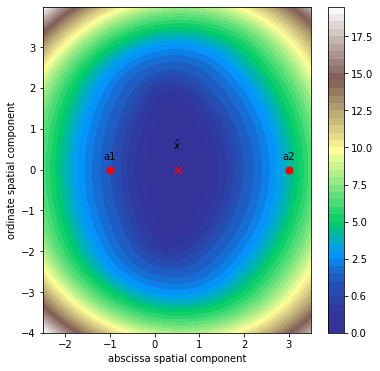

In [45]:
plot_contours_cvx_ranges(convex_function, data, plot_data, 2, 2)

## 2. Adding angle measurements

* $\textbf{angles_function(x, a, angles, m, prob_dim, nb_data_points)}$:
function that implements the angle measurement terms in cost function. it works for n-dimensional case and for m anchor-angle pairs $(a_1,\theta_1), ..., (a_m,\theta_m)$
* x = meshgrid with domain points
* a = array with the anchors
* angles = array with the angles in degrees
* m = number of anchors
* prob_dim = problem dimension n
* nb_data_points = number of points in meshgrid

In [46]:
def angles_function(x, a, angles, m, prob_dim, nb_data_points):
    # number of data points
    nb_data_points =  nb_data_points * m
    # get vector directions (of unit-magnitude) with respect to given angles
    u = np.column_stack((np.cos(np.radians(angles)), np.sin(np.radians(angles))))[:, np.newaxis]
    
    # loop over the anchors and store the matrices u_k * u_k^T, for each direction
    outer_vals = list()
    for k in range(m):
        outer = np.outer(u[k], u[k])
        outer_vals.append(outer)
    
    # set matrices from previous outer products as a numpy array    
    outer_mats = np.array(outer_vals)
    # generate the array with the matrices I - u_k * u_k^T
    proj_operator_vals = np.eye(prob_dim) - outer_mats
    
    # generate the tensor product of meshgrid in x - a with array with the matrices I - u_k * u_k^T
    projections = np.tensordot(x - a, proj_operator_vals, (prob_dim, -prob_dim))
    projections = projections.reshape(m, nb_data_points, prob_dim)
    
    res_aux1 = list()
    # indexes to select the projection terms of the angle measurements terms in cost function,
    # from reshaped tensor product
    idxs = np.arange(0, nb_data_points, m)
    # loop over the number of anchors to select each term (I - u_k * u_k^T)(x - a_k), for k=1,...,m
    # from projections tensor array
    for k in range(m):
        aux_res = projections[k, idxs, :]
        res_aux1.append(aux_res)
        idxs = idxs + 1
    
    # get the normed squares
    res_aux2 = np.linalg.norm(res_aux1, axis=-1) ** 2
    # sum the squares
    res_out = np.sum(res_aux2, axis=0)
    
    return res_out

* $\textbf{plot_contours_angles(cost_function, data, plot_data, prob_dim, plot_type)}$: function to produce the contour plots for cost function with angle measurement terms. it works for the 2D case, as for plotting the contours as requred, and for m anchor-angle tuples $(a_1,\theta_1), ..., (a_m,\theta_m)$, and produces two twin plots with the possibility of considering diferent number of tuples in each plot. in our case the plot on the left is for one anchor and the plot on the right is for two anhors.  
* cost_function1 = funtion with range terms
* cost_function2 = function with angle terms
* data = [anchors1, angles1, anchors2, angles2, delta], delta is the step size for spatial points in domain
* plot_data = [range_x1, range_y1, range_x2, range_y2, levels1, levels2], levels for the contours
* prob_dim = problem dimension 2
* plot_type = 1 for contour levels and 2 for filled contours

this function is not commented because it is similar to previous plot contour functions

In [47]:
def plot_contours_angles(cost_function, data, plot_data, prob_dim, plot_type):
    
    anchors1, angles1, anchors2, angles2, delta = data[0], data[1], data[2], data[3], data[4]
    plot_dim_x1, plot_dim_y1, plot_dim_x2, plot_dim_y2 = plot_data[0], plot_data[1], plot_data[2], plot_data[3]
    levels1, levels2 = plot_data[4], plot_data[5]
        
    x1, x2 = np.arange(*plot_dim_x1, delta), np.arange(*plot_dim_x2, delta)
    y1, y2 = np.arange(*plot_dim_y1, delta), np.arange(*plot_dim_y2, delta)
       
    X1, Y1 = np.meshgrid(x1, y1)
    X2, Y2 = np.meshgrid(x2, y2)
    grid_points1 = np.dstack((X1, Y1)).reshape(-1, 2)
    grid_points2 = np.dstack((X2, Y2)).reshape(-1, 2)
    
    anchors1, anchors2 = np.array(anchors1), np.array(anchors2)
    angles1, angles1 = np.array(angles1), np.array(angles2)
    
    m1, m2 = len(anchors1), len(anchors2)
    nb_data_points1 = np.shape(grid_points1)[0]
    nb_data_points2 = np.shape(grid_points2)[0]
        
    Z1 = cost_function(grid_points1, anchors1[:, np.newaxis], angles1, m1, prob_dim, nb_data_points1)
    Z1 = Z1.reshape(X1.shape)
        
    Z2 = cost_function(grid_points2, anchors2[:, np.newaxis], angles2, m2, prob_dim, nb_data_points2)
    Z2 = Z2.reshape(X2.shape)
    
    if plot_type == 1:
        fig = plt.figure(figsize=(12,6))
        
        ax = fig.add_subplot(1, 2, 1)
        label = 1
        for point in anchors1:
            x_anchor, y_anchor = point
            ax.scatter(x_anchor, y_anchor, c='red', marker='o', s=50)
            ax.annotate('a' + str(label), (x_anchor, y_anchor), textcoords="offset points", xytext=(0, 10), ha='center')
            label += 1
            
        CS = ax.contour(X1, Y1, Z1, levels=levels1, cmap='terrain')
        ax.clabel(CS, inline=True, fontsize=10)
        
        ax.set_xlabel('abscissa spatial component')
        ax.set_ylabel('ordinate spatial component')
        plt.colorbar(CS)
            
        ax = fig.add_subplot(1, 2, 2)
        
        label = 1
        for point in anchors2:
            x_anchor, y_anchor = point
            ax.scatter(x_anchor, y_anchor, c='red', marker='o', s=50)
            ax.annotate('a' + str(label), (x_anchor, y_anchor), textcoords="offset points", xytext=(0, 10), ha='center')
            label += 1
            
        CS = ax.contour(X2, Y2, Z2, levels=levels2, cmap='terrain')
        ax.clabel(CS, inline=True, fontsize=10)
        
        ax.set_xlabel('abscissa spatial component')
        ax.set_ylabel('ordinate spatial component')
        plt.colorbar(CS)
        
    else:
        fig = plt.figure(figsize=(12,6))
 
        ax = fig.add_subplot(1, 2, 1)
        CS = plt.contourf(X1, Y1, Z1, levels=levels1, cmap='terrain')
        
        label = 1
        for point in anchors1:
            x_anchor, y_anchor = point
            plt.scatter(x_anchor, y_anchor, c='red', marker='o', s=50)
            plt.annotate('a' + str(label), (x_anchor, y_anchor), textcoords="offset points", xytext=(0, 10), ha='center')
            label += 1
        
        plt.xlabel('abscissa spatial component')
        plt.ylabel('ordinate spatial component')
        plt.colorbar(CS)
            
        ax = fig.add_subplot(1, 2, 2)
        CS = plt.contourf(X2, Y2, Z2, levels=levels2, cmap='terrain')

        label = 1
        for point in anchors2:
            x_anchor, y_anchor = point
            plt.scatter(x_anchor, y_anchor, c='red', marker='o', s=50)
            plt.annotate('a' + str(label), (x_anchor, y_anchor), textcoords="offset points", xytext=(0, 10), ha='center')
            label += 1
            
        plt.xlabel('abscissa spatial component')
        plt.ylabel('ordinate spatial component')
        plt.colorbar(CS)
        
    plt.show()

* $\textbf{cvx_solution_ranges_angles(anchors, ranges, directions, m, prob_dim)}$: function to produce the approximate solution of the relaxed problem with range and angle measurements, using cvx. it works for an n-dimensional problem and for m anchor-range-angle tuples $(a_1,r_1,\theta_1),...,(a_m,r_m,\theta_m)$ 

* this function is not commented because it is similar to the previous cvx function and to which we add the angle terms in cvx setting

In [48]:
def cvx_solution_ranges_angles(anchors, ranges, directions, m, prob_dim):
    x_var = cp.Variable(prob_dim)
    anchors = np.array(anchors)
    ranges = np.array(ranges)
    diff_vals = list()
        
    for anchor in anchors:
        diff = x_var - anchor
        diff_vals.append(diff)
        
    diff_vec = cp.vstack(diff_vals)
    
    outer_vals = list()
    for u in directions:
        outer = np.outer(u, u)
        outer_vals.append(outer)
    
    outer_mats = np.array(outer_vals)
    proj_operator_vals = np.eye(prob_dim) - outer_mats
    
    proj_vals = list()
    for k in range(m):
        proj = proj_operator_vals[k] @ diff_vec[k]
        proj_vals.append(proj)
    
    proj_vals_vec = cp.vstack(proj_vals)
    
    range_terms = cp.sum(cp.square(cp.maximum(0, cp.norm(diff_vec, axis=1) - ranges)))
    angle_terms = cp.sum(cp.square(cp.norm(proj_vals_vec, axis=1)))
    cost_function = range_terms + angle_terms
    
    objective = cp.Minimize(cost_function)
    
    problem = cp.Problem(objective)
    problem.solve()
    optimal_x = x_var.value
    prob_status = problem.status
    prob_value = problem.value
    
    return [np.array(optimal_x), prob_status, np.array(prob_value)]

* $\textbf{plot_contours_cvx_ranges_angles(cost_function1, cost_function2, data, plot_data, prob_dim, plot_type)}$:
function to produce the contour plots for cost function with range and angle measurement terms. it works for the 2D case, as for plotting the contours, and for m anchor-range-angle tuples $(a_1,r_1,\theta_1), ..., (a_m,r_m,\theta_m)$, and produces two twin plots with the possibility of considering diferent number of tuples in each plot. in our case the plot on the left is for one anchor and the plot on the right is for two anhors.  
* cost_function1 = funtion with range terms
* cost_function2 = function with angle terms
* data = [anchors1, ranges1, angles1, anchors2, ranges2, angles2, delta], delta is the step size for spatial points in domain
* plot_data = [range_x1, range_y1, range_x2, range_y2, levels1, levels2], levels for the contours
* prob_dim = problem dimension 2
* plot_type = 1 for contour levels and 2 for filled contours

* this function is not commented because it is similar to previous plot contour functions

In [49]:
def plot_contours_cvx_ranges_angles(cost_function1, cost_function2, data, plot_data, prob_dim, plot_type):
    
    anchors1, ranges1, angles1 = data[0], data[1], data[2]
    anchors2, ranges2, angles2, delta = data[3], data[4], data[5], data[6]
    plot_dim_x1, plot_dim_y1, plot_dim_x2, plot_dim_y2 = plot_data[0], plot_data[1], plot_data[2], plot_data[3]
    levels1, levels2 = plot_data[4], plot_data[5]
        
    x1, x2 = np.arange(*plot_dim_x1, delta), np.arange(*plot_dim_x2, delta)
    y1, y2 = np.arange(*plot_dim_y1, delta), np.arange(*plot_dim_y2, delta)
        
    X1, Y1 = np.meshgrid(x1, y1)
    X2, Y2 = np.meshgrid(x2, y2)
    grid_points1 = np.dstack((X1, Y1)).reshape(-1, 2)
    grid_points2 = np.dstack((X2, Y2)).reshape(-1, 2)
    
    anchors1, anchors2 = np.array(anchors1), np.array(anchors2)
    ranges1, ranges2 = np.array(ranges1), np.array(ranges2)
    angles1, angles1 = np.array(angles1), np.array(angles2)

    m1, m2 = len(anchors1), len(anchors2)
    nb_data_points1 = np.shape(grid_points1)[0]
    nb_data_points2 = np.shape(grid_points2)[0]
        
    directions1 = np.column_stack((np.cos(np.radians(angles1)), np.sin(np.radians(angles1))))[:, np.newaxis]
    directions2 = np.column_stack((np.cos(np.radians(angles2)), np.sin(np.radians(angles2))))[:, np.newaxis]
        
    res1_cvx = cvx_solution_ranges_angles(anchors1, ranges1, directions1, m1, prob_dim)
    res2_cvx = cvx_solution_ranges_angles(anchors2, ranges2, directions2, m2, prob_dim)
    print('CVX result for one anchor:')
    print('The obtained (approx) optimal solution is x = ', res1_cvx[0])
    print('Problem status solution: ', res1_cvx[1])
    print('Cost value at obtained solution: ', res1_cvx[2])
    print('\nCVX result for two anchor:')
    print('The obtained (approx) optimal solution is x = ', res2_cvx[0])
    print('Problem status solution: ', res2_cvx[1])
    print('Cost value at obtained solution: ', res2_cvx[2])
        
    Z1 = cost_function1(grid_points1, anchors1[:, np.newaxis], angles1, m1, prob_dim, nb_data_points1) + \
            cost_function2(grid_points1, anchors1[:, np.newaxis], ranges1[:, np.newaxis])
    Z1 = Z1.reshape(X1.shape)
        
    Z2 = cost_function1(grid_points2, anchors2[:, np.newaxis], angles2, m2, prob_dim, nb_data_points2) + \
            cost_function2(grid_points2, anchors2[:, np.newaxis], ranges2[:, np.newaxis])
    Z2 = Z2.reshape(X2.shape)
    
    if plot_type == 1:
        fig = plt.figure(figsize=(12,6))
        
        ax = fig.add_subplot(1, 2, 1)
        
        label = 1
        for point in anchors1:
            x_anchor, y_anchor = point
            ax.scatter(x_anchor, y_anchor, c='red', marker='o', s=50)
            ax.annotate('a' + str(label), (x_anchor, y_anchor), textcoords="offset points", xytext=(0, 10), ha='right')
            label += 1
            
        ax.scatter(res1_cvx[0][0], res1_cvx[0][1], c='k', marker='x', s=50)
        ax.annotate('$\hat{x}$', (res1_cvx[0][0], res1_cvx[0][1]), textcoords="offset points", xytext=(0, 10), ha='left')
                        
        CS = ax.contour(X1, Y1, Z1, levels=levels1, cmap='terrain')
        ax.clabel(CS, inline=True, fontsize=10)
        
        ax.set_xlabel('abscissa spatial component')
        ax.set_ylabel('ordinate spatial component')
        plt.colorbar(CS)
            
        ax = fig.add_subplot(1, 2, 2)
        
        label = 1
        for point in anchors2:
            x_anchor, y_anchor = point
            ax.scatter(x_anchor, y_anchor, c='red', marker='o', s=50)
            ax.annotate('a' + str(label), (x_anchor, y_anchor), textcoords="offset points", xytext=(0, 10), ha='center')
            label += 1
                
        ax.scatter(res2_cvx[0][0], res2_cvx[0][1], c='red', marker='x', s=50)
        ax.annotate('$\hat{x}$', (res2_cvx[0][0], res2_cvx[0][1]), textcoords="offset points", xytext=(0, 10), ha='center')
            
        CS = ax.contour(X2, Y2, Z2, levels=levels2, cmap='terrain')
        ax.clabel(CS, inline=True, fontsize=10)
        
        ax.set_xlabel('abscissa spatial component')
        ax.set_ylabel('ordinate spatial component')
        plt.colorbar(CS)
        
    else:
        fig = plt.figure(figsize=(12,6))
        
        ax = fig.add_subplot(1, 2, 1)
        CS = plt.contourf(X1, Y1, Z1, levels=levels1, cmap='terrain')
        
        label = 1
        for point in anchors1:
            x_anchor, y_anchor = point
            plt.scatter(x_anchor, y_anchor, c='r', marker='o', s=50)
            plt.annotate('a' + str(label), (x_anchor, y_anchor), textcoords="offset points", xytext=(0, 10), ha='right')
            label += 1
        
        ax.scatter(res1_cvx[0][0], res1_cvx[0][1], c='k', marker='x', s=50)
        ax.annotate('$\hat{x}$', (res1_cvx[0][0], res1_cvx[0][1]), textcoords="offset points", xytext=(0, 10), ha='left')
            
        plt.xlabel('abscissa spatial component')
        plt.ylabel('ordinate spatial component')
        plt.colorbar(CS)
        
        ax = fig.add_subplot(1, 2, 2)
        CS = plt.contourf(X2, Y2, Z2, levels=levels2, cmap='terrain')
        
        label = 1
        for point in anchors2:
            x_anchor, y_anchor = point
            plt.scatter(x_anchor, y_anchor, c='red', marker='o', s=50)
            plt.annotate('a' + str(label), (x_anchor, y_anchor), textcoords="offset points", xytext=(0, 10), ha='center')
            label += 1
        
        ax.scatter(res2_cvx[0][0], res2_cvx[0][1], c='red', marker='x', s=50)
        ax.annotate('$\hat{x}$', (res2_cvx[0][0], res2_cvx[0][1]), textcoords="offset points", xytext=(0, 10), ha='center')
        
        plt.xlabel('abscissa spatial component')
        plt.ylabel('ordinate spatial component')
        plt.colorbar(CS)
        
    plt.show()

### 2.1 Task 7

* contour plots with contour levels for one anchor and for two anchors

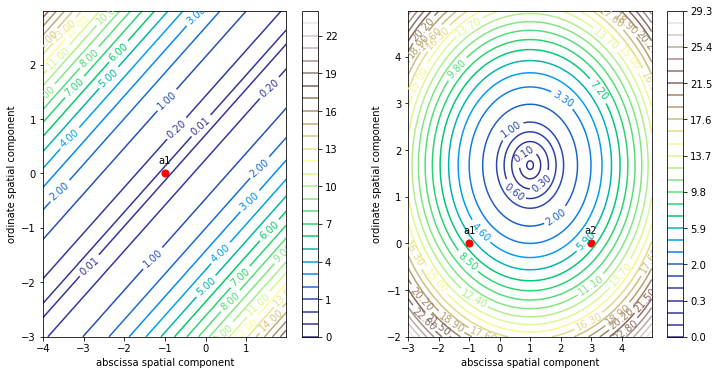

In [50]:
anchors1, anchors2 = [(-1,0)], [(-1,0), (3,0)]
angles1, angles2 = [40], [40, 140]
delta = 0.01

plot_dim_x1, plot_dim_x2 = (-4,2), (-3,5) 
plot_dim_y1, plot_dim_y2 = (-3,3), (-2,5)
levels1 = np.array([0, 0.01, 0.2] + list(np.arange(1,25,1)))
levels2 = np.array([0, 0.01, 0.1, 0.3, 0.6, 1] + list(np.arange(2,30,1.3)))

data = [anchors1, angles1, anchors2, angles2, delta]
plot_data = [plot_dim_x1, plot_dim_y1, plot_dim_x2, plot_dim_y2, levels1, levels2]

prob_dim = 2
plot_type = 1

plot_contours_angles(angles_function, data, plot_data, prob_dim, plot_type)

* contour plots with filled contours for one anchor and for two anchors

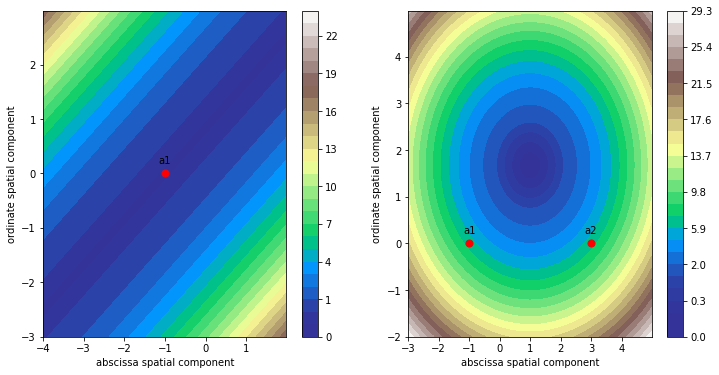

In [51]:
plot_type = 2

plot_contours_angles(angles_function, data, plot_data, prob_dim, plot_type)

### 2.2 Task 8

* contour plots with contour levels for one anchor and for two anchors

CVX result for one anchor:
The obtained (approx) optimal solution is x =  [-9.99870074e-01  1.09020480e-04]
Problem status solution:  optimal
Cost value at obtained solution:  5.920866272205753e-25

CVX result for two anchor:
The obtained (approx) optimal solution is x =  [0.72942253 1.51167551]
Problem status solution:  optimal
Cost value at obtained solution:  0.18123485892331148


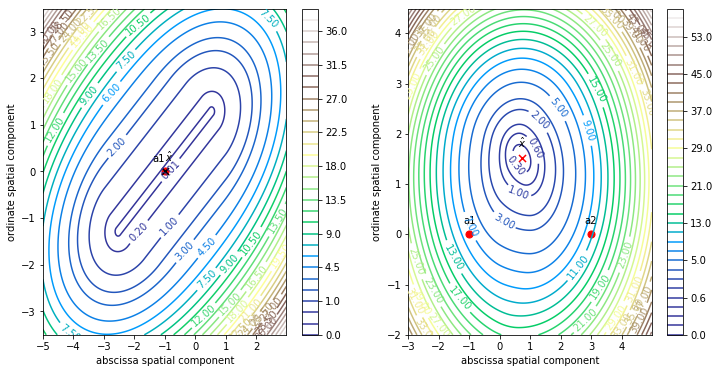

In [52]:
anchors1, anchors2 = [(-1,0)], [(-1,0), (3,0)]
ranges1, ranges2 = [2], [2, 3]
angles1, angles2 = [40], [40, 140]
delta = 0.01

plot_dim_x1, plot_dim_x2 = (-5,3), (-3,5) 
plot_dim_y1, plot_dim_y2 = (-3.5,3.5), (-2,4.5)
levels1 = np.array([0, 0.01, 0.2, 1, 2] + list(np.arange(3,40,1.5)))
levels2 = np.array([0, 0.01, 0.1, 0.3, 0.6, 1, 2] + list(np.arange(3,60,2)))

data = [anchors1, ranges1, angles1, anchors2, ranges2, angles2, delta]
plot_data = [plot_dim_x1, plot_dim_y1, plot_dim_x2, plot_dim_y2, levels1, levels2]

prob_dim = 2
plot_type = 1

plot_contours_cvx_ranges_angles(angles_function, convex_function, data, plot_data, prob_dim, plot_type)

* contour plots with filled contours for one anchor and for two anchors

CVX result for one anchor:
The obtained (approx) optimal solution is x =  [-9.99870074e-01  1.09020480e-04]
Problem status solution:  optimal
Cost value at obtained solution:  5.920866272205753e-25

CVX result for two anchor:
The obtained (approx) optimal solution is x =  [0.72942253 1.51167551]
Problem status solution:  optimal
Cost value at obtained solution:  0.18123485892331148


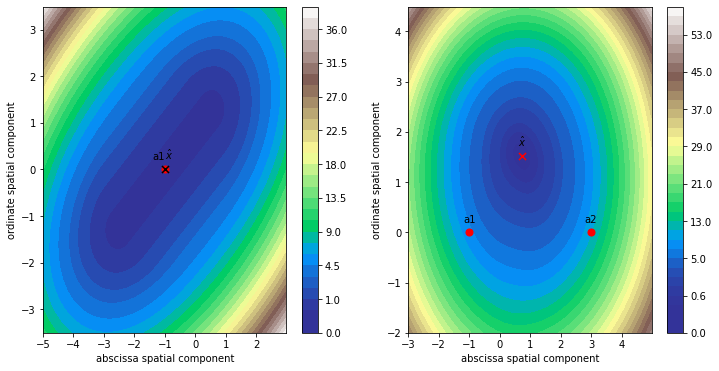

In [53]:
plot_type = 2

plot_contours_cvx_ranges_angles(angles_function, convex_function, data, plot_data, prob_dim, plot_type)